In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import optical_gating_analysis as OG
import hrv_analysis as hrv

# Run analysis

In [2]:
import glob
oogs = []
sequence_src = r"E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\second fish\2024-06-19 16.39.55 vid\Allied Vision Technologies GS650 0001f61c\*tif"
file_list = sorted(glob.glob(sequence_src))
for file in tqdm(file_list):
    oog = OG.BasicOpticalGating()
    oog.settings["progress_bars"] = False
    oog.settings["show_status"] = False
    oog.sequence_manager.set_source(file)
    #oog.sequence_manager.set_reference_sequence(r"E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\second fish\2024-06-19 16.39.55 vid\ref-frames-2024-06-19-16.39.54\551441.tif")
    #oog.sequence_manager.reference_period = 53.690834
    oog.settings["include_reference_frames"] = False
    oog.run()
    oogs.append(oog)

100%|██████████| 219/219 [06:33<00:00,  1.80s/it]


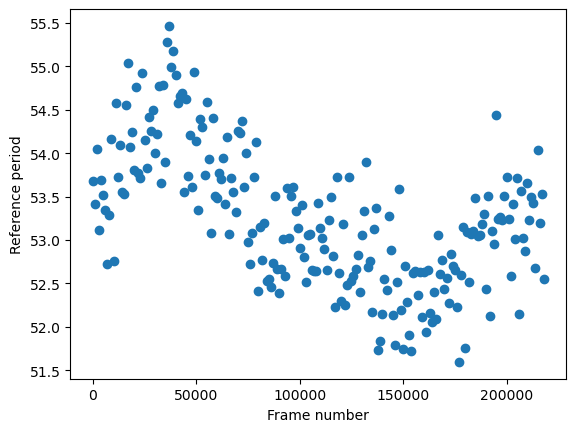

In [156]:
periods = []
for _oog in oogs:
    periods.append(_oog.sequence_manager.reference_period)

plt.scatter(1000 * np.arange(len(periods)), periods)
plt.xlabel("Frame number")
plt.ylabel("Reference period")
plt.show()

In [3]:
sequence_src = r"E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\second fish\2024-06-19 16.39.55 vid\Allied Vision Technologies GS650 0001f61c\*tif"
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(sequence_src)
oog.sequence_manager.framerate = 120
oog.settings["include_reference_frames"] = False
oog.run()

Setting source to E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\second fish\2024-06-19 16.39.55 vid\Allied Vision Technologies GS650 0001f61c\*tif
Getting reference sequence Reference period: 53.68333142004362; Reference indices: [10, 68]


Getting SADs: 100%|██████████| 219/219 [05:06<00:00,  1.40s/it]


Getting phases


# Analysis
First we look at the full sequence where we see the "weird" phase estimates.

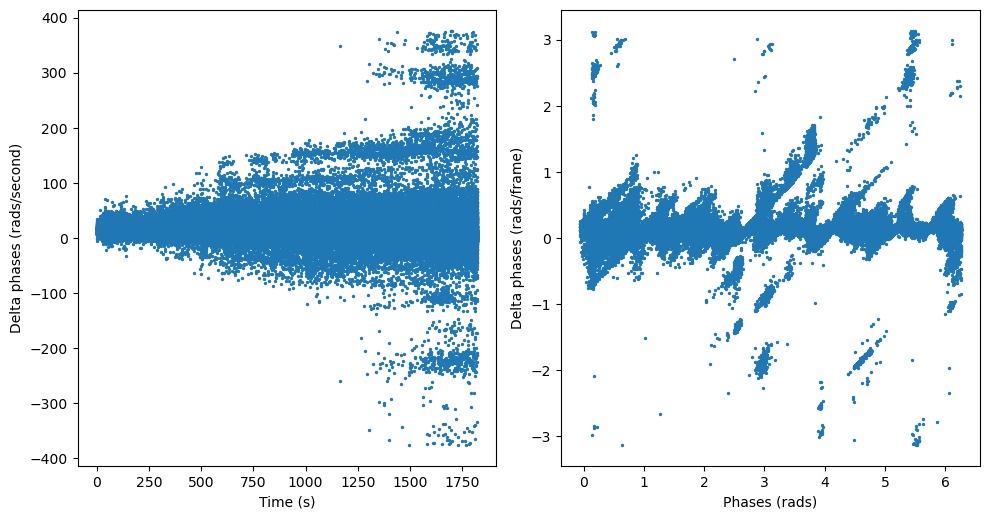

In [165]:
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.scatter((np.arange(len(oog.delta_phases)) / oog.sequence_manager.framerate), oog.delta_phases * oog.sequence_manager.framerate, s = 2)
plt.xlabel("Time (s)")
plt.ylabel("Delta phases (rads/second)")
plt.subplot(222)
plt.scatter(oog.phases[1::], oog.delta_phases, s = 2)
#plt.scatter(oog.phases[1::], oog.delta_phases, s = 2)
plt.xlabel("Phases (rads)")
plt.ylabel("Delta phases (rads/frame)")
plt.tight_layout()
plt.show()

Here we can see that the phase estimates seem reasonable but diverge at around 7 minutes. We can see that there also seems to be a phase-dependence to this divergence.

Next we look at the data where the reference sequence is regenerated each frame. NOTE: the ref sequences are not aligned.

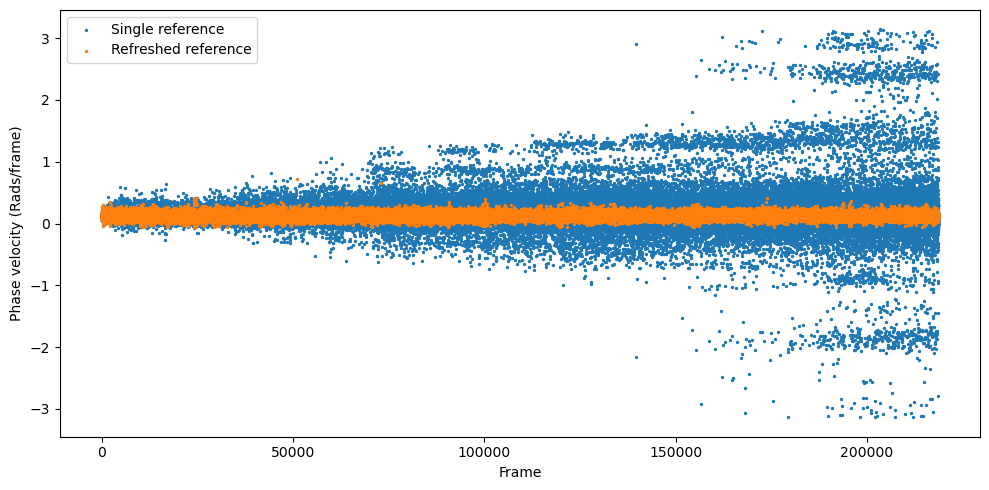

In [46]:
plt.figure(figsize = (10,5))
plt.scatter((np.arange(len(oog.delta_phases))), oog.delta_phases, s = 2, label = "Single reference", c = "tab:blue")
startat = 0
for i in range(len(oogs)):
    #startat += oogs[i].sequence_manager.reference_indices[1]
    grp = plt.scatter((startat + np.arange(len(oogs[i].delta_phases))), oogs[i].delta_phases, s = 2, c = "tab:orange")
    startat += 1000#len(oogs[i].delta_phases)
grp.set_label("Refreshed reference")
plt.xlabel("Frame")
plt.ylabel("Phase velocity (Rads/frame)")
plt.legend()
plt.tight_layout()
plt.show()

We can see that the refreshed ref sequence don't produce the weird phase anomalies.

Looking at the phase-delta-phase plot. We do see a single anomaly. this suggests it perhaps gets "stuck" on one of the early phases. I suspect this is because our reference sequence is included in our full data.

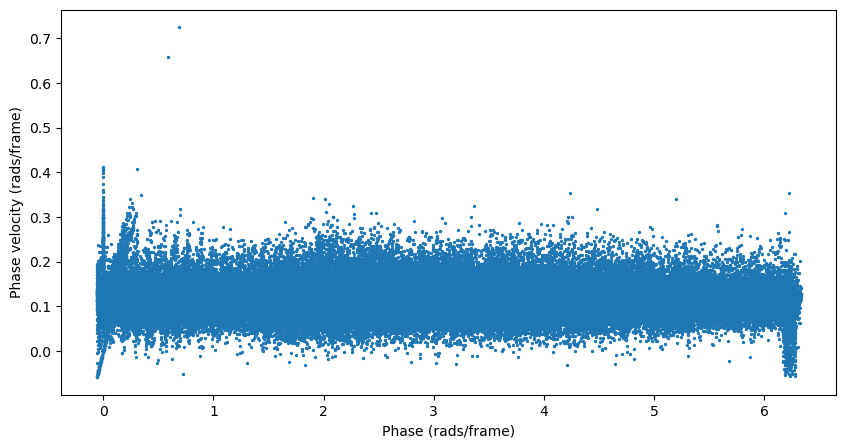

In [47]:
plt.figure(figsize = (10,5))
for _oog in oogs:
    plt.scatter(_oog.phases[1::], _oog.delta_phases, s = 2, c = "tab:blue")

plt.xlabel("Phase (rads/frame)")
plt.ylabel("Phase velocity (rads/frame)")
plt.show()

Next we look at the bad sequence's SADs.

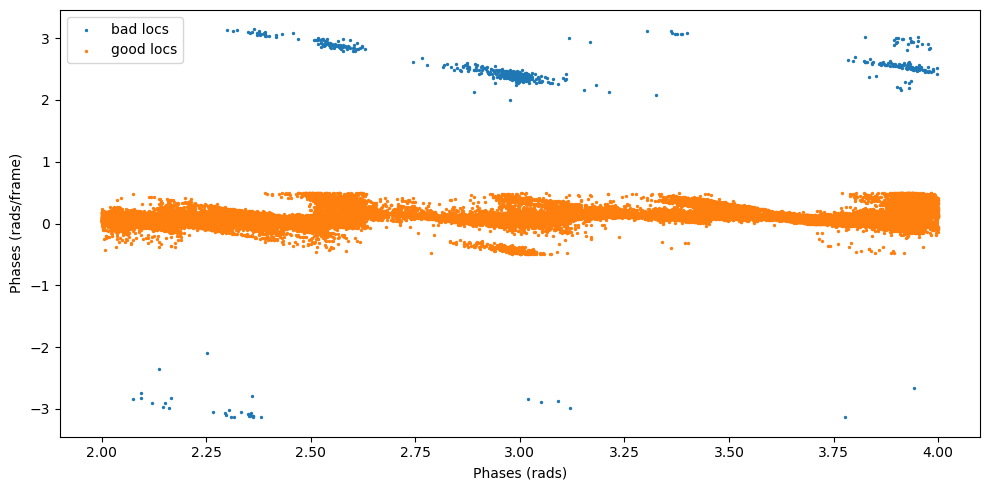

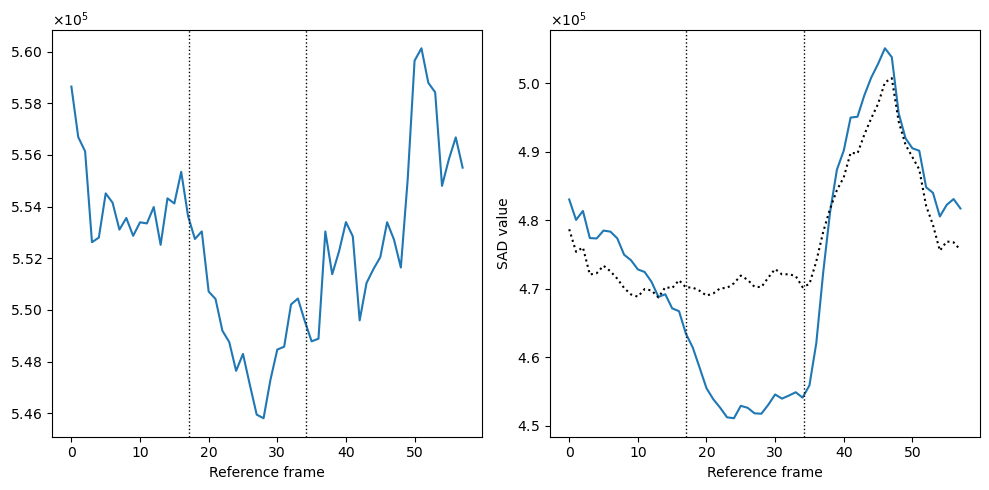

In [161]:
phase_min = 2
phase_max = 4
outlier = 2
very_bad_locs = np.where((np.abs(oog.delta_phases) > outlier) & (oog.phases[0:-1] > phase_min) & (oog.phases[0:-1] < phase_max))
outlier = 0.5
good_locs = np.where((np.abs(oog.delta_phases) < outlier) & (oog.phases[0:-1] > phase_min) & (oog.phases[0:-1] < phase_max))
overall_mean_good = np.where(oog.delta_phases < outlier)

plt.figure(figsize = (10,5))
plt.scatter(oog.phases[0:-1][very_bad_locs], oog.delta_phases[very_bad_locs], s = 2, label = "bad locs")
plt.scatter(oog.phases[0:-1][good_locs], oog.delta_phases[good_locs], s = 2, label = "good locs")
plt.xlabel("Delta Phases (rads)")
plt.ylabel("Phases (rads/frame)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(np.mean(np.array(oog.sads)[very_bad_locs], axis = 0))
plt.axvline(oog.sequence_manager.reference_period * phase_min / (2 * np.pi), lw = 1, ls = ":", c = "black")
plt.axvline(oog.sequence_manager.reference_period * phase_max / (2 * np.pi), lw = 1, ls = ":", c = "black")
plt.xlabel("Reference frame")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

plt.subplot(122)
plt.plot(np.mean(np.array(oog.sads)[good_locs], axis = 0))
plt.axvline(oog.sequence_manager.reference_period * phase_min / (2 * np.pi), lw = 1, ls = ":", c = "black")
plt.axvline(oog.sequence_manager.reference_period * phase_max / (2 * np.pi), lw = 1, ls = ":", c = "black")
plt.plot(np.mean(np.array(oog.sads)[overall_mean_good], axis = 0), ls = ":", c = "black", label = "Overall good average")
plt.xlabel("Reference frame")
plt.ylabel("SAD value")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.tight_layout()
plt.show()

We can see that on average the reference sequence looks more noisy with some significant minima sppikes such that frame 55 looks very similar to frame 35. Conversely on the "healthy" frames we don't see this. It seems like we are "sticking" to a certain frame.